# Задание 1#

### Напишем генерацию точек: ###
#### 1) Разделяемый набор ####
Генерируем произвольную прямую через 3 случайных числа (коэффициентов уравнения $ax + by + c = 0$). Затем генерируем случайное количество точек с каждой стороны. Каждая точка описывается 2-мя цифрами: расстояние от прямой и координата проекции.

In [1]:
import random
import math
import numpy as np
import scipy.stats as ssp
from matplotlib import pyplot as plt
from math import log
from scipy.optimize import linprog
%matplotlib inline

In [317]:
LINE_COEFF = 100.
POINTS_COEFF = 1
POINTS_NUMBER = 1000

#Вывод графиков

def plot_points(points, line=None):
    fig = plt.figure(figsize=(15, 10))    
    plot_points = np.array(points)
    
    plt.axis([np.min(plot_points[0, :, 0]),
              np.max(plot_points[1, :, 0]),
              np.min(plot_points[1, :, 1]),
              np.max(plot_points[0, :, 1])])

    plt.scatter(plot_points[0, :, 0], plot_points[0, :, 1], color='blue')
    plt.scatter(plot_points[1, :, 0], plot_points[1, :, 1], color='red')
    if (not line == None):
        line_x = [0, POINTS_COEFF]
        line_y = [-(line[0] * line_x[0] + line[2]) / line[1], 
                  -(line[0] * line_x[1] + line[2]) / line[1]]
        plt.plot(line_x, line_y, color='black', linewidth=10)
    plt.show()

In [318]:
def get_line_y(curr_x, line):
    return (-1.) * (line[2] + line[0] * curr_x) / line[1]

def get_side(index):
    if index == 0:
        return 1
    if index == 1:
        return -1
    
def generate_point(line, j):
    x = random.random() * POINTS_COEFF
    return [x, get_line_y(x, line) + (random.random() * POINTS_COEFF * get_side(j))]
    
line = [random.random() * LINE_COEFF for i in range(3)]

points_devide = [[generate_point(line, j)
             for i in range(POINTS_NUMBER)] 
            for j in range(2)]

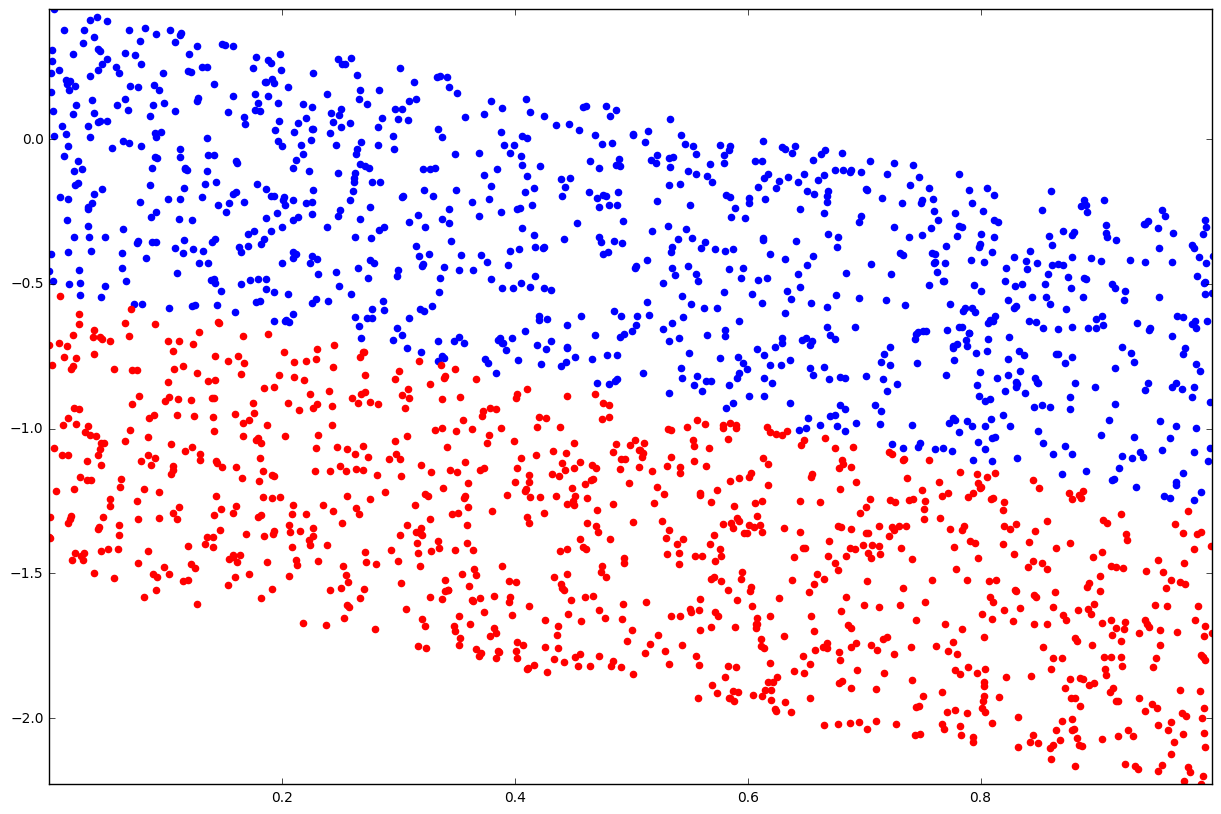

In [319]:
plot_points(points_devide)

#### 2) Неразделяемый набор ####
Просто генерируем большое количество случайных точек

In [320]:
points_nondevide = [[[random.random() * POINTS_COEFF, random.random() * POINTS_COEFF]
             for i in range(POINTS_NUMBER)] 
            for j in range(2)]

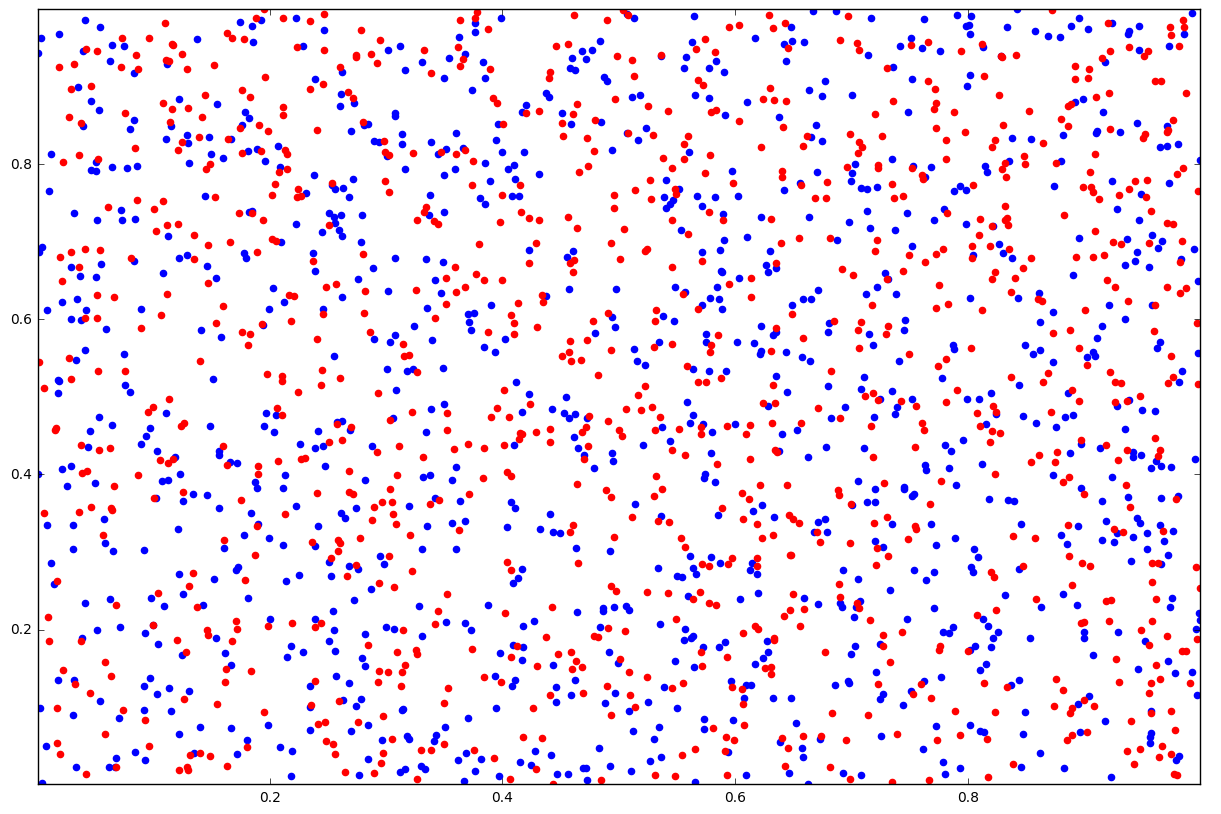

In [321]:
plot_points(points_nondevide)

### Метод градиентного спуска ###

#### Градиент функции ####

Найдём его аналитически:

$$ Q \left( \omega \right) = \sum\limits_{i=1}^{m}{ln \left( 1 + e^{-y_i \left<x_i, \omega \right> } \right) } $$:
$$ \cfrac{ d Q}{ d \omega_j} = \sum\limits_{i = 1}^{m}{\cfrac{-y_i x_i^j e^{-y_i\left< x_i, \omega \right>}}{1 + e^{-y_i\left< x_i, \omega\right>}}}$$

#### Описание алгоритма ####

Для начала, всем точкам добавим первою координату, равную $-1$.
Затем запустим градиентный спуск, где $\lambda$ будет каждый раз уменьшаться в константное количество раз, а индикатором отсановки будет мальнькое расстояние между соседними итерациями алгоритма.

In [389]:
def upgrade_points(points_first, points_second):
    points = [np.array([-1] + i) for i in points_first] \
           + [np.array([-1] + i) for i in points_second]
    classes = [-1 for i in range(len(points_first))] \
            + [1 for i in range(len(points_second))]
    return np.array(points), np.array(classes)


def FUNC_GRAD(curr_point, points, index, dimention, classes):
    scalar = (points * curr_point).sum(axis=1)
    return (((-1) * classes * points[:, index]) \
           + classes * points[:, index] \
           / (1 + np.exp((-1) * classes * scalar))).sum()


def LAMBD():
    global LAMBDA
    LAMBDA *= 0.998
    return LAMBDA

def LAMBD_2():
    return 1e-5


def get_new_point(curr_point, points, func_grad, lambd, dimention, classes):
    return np.array([curr_point[i] - (lambd() \
            * func_grad(curr_point, points, i, dimention, classes))
            for i in range(dimention + 1)])
    
    
def stop_condition(curr_point, next_point, eps):
    return ((curr_point - next_point) ** 2).sum() ** 0.5 < eps


def gradient_down(start_point, points, func_grad, lambd, dimention, classes, eps):
    curr_point = start_point
    new_point = get_new_point(curr_point, points, 
                              func_grad, lambd, 
                              dimention, classes)
    counter = 0   
    while (not stop_condition(curr_point, new_point, eps)):
        counter += 1
        curr_point = new_point
        new_point = get_new_point(curr_point, points, 
                                  func_grad, lambd, dimention, classes)
    return new_point, counter

### Запустим наш алгоритм на разделяемом наборе: ###

In [328]:
EPS = 10e-9
DIMENTION = 2
LAMBDA = 10

start_point = np.array([1, 1, 1])
points, classes = upgrade_points(points_devide[0], points_devide[1])

answer, counter = gradient_down(start_point, points, 
                                FUNC_GRAD, LAMBD, 
                                DIMENTION, classes, EPS)
answer = [answer[1], answer[2], -answer[0]]

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in exp


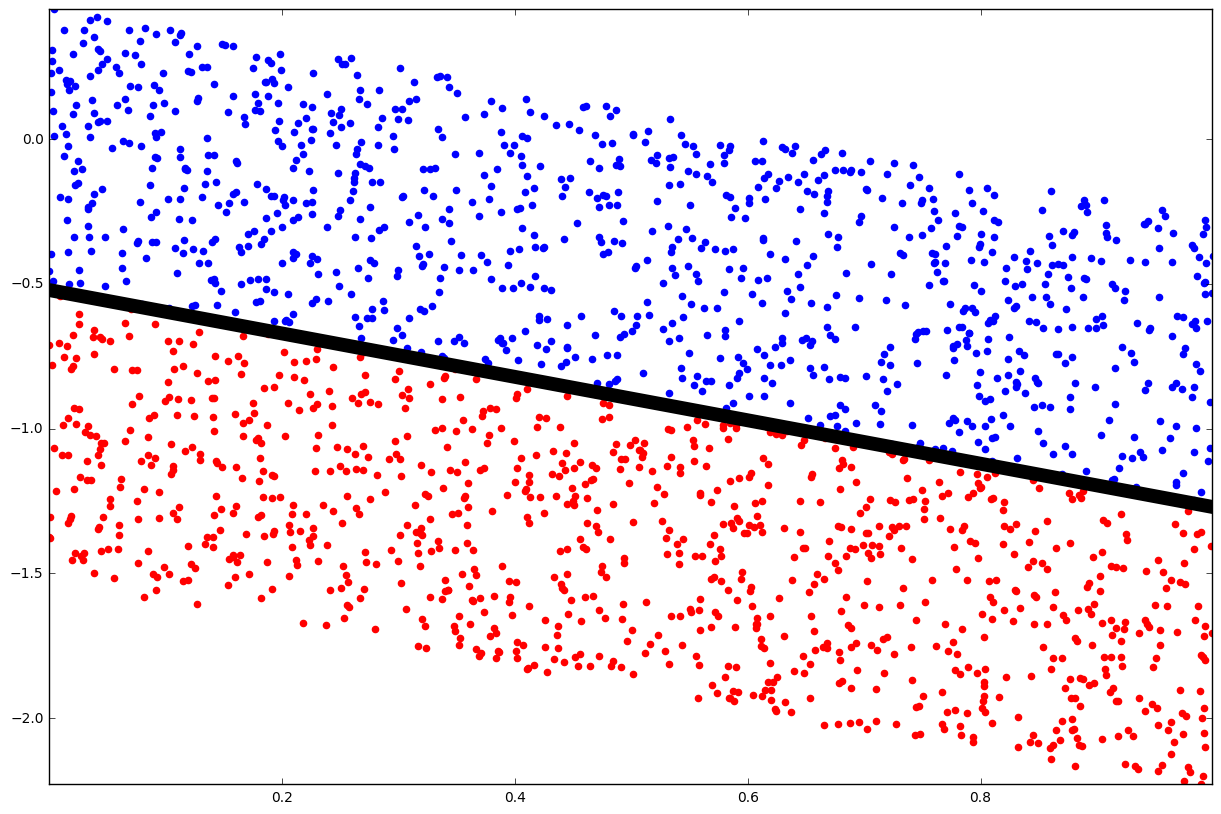

In [329]:
plot_points(points_devide, line=answer)

### И на неразделяемом: ###

In [330]:
EPS = 10e-9
DIMENTION = 2
LAMBDA = 10
start_point = np.array([1, 1, 1])
points, classes = upgrade_points(points_nondevide[0], points_nondevide[1])

answer, counter = gradient_down(start_point, points, 
                                FUNC_GRAD, LAMBD, 
                                DIMENTION, classes, EPS)
answer = [answer[1], answer[2], -answer[0]]

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in exp


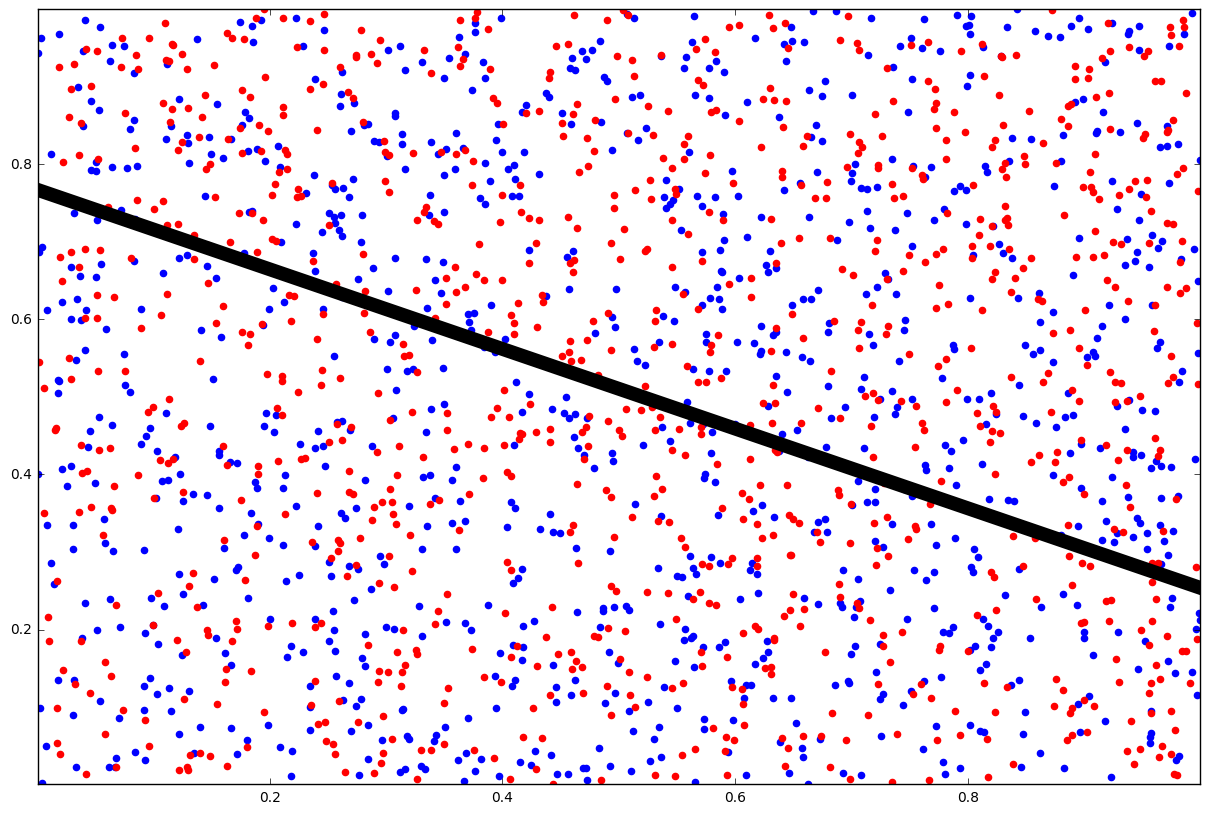

In [331]:
plot_points(points_nondevide, line=answer)

### Посмотрим на зависимость количества шагов от точности: ###

In [395]:
eps = [10 ** (-i) for i in range(1, 12)]
eps = eps[::-1]

DIMENTION = 2
start_point = np.array([1, 1, 1])
points, classes = upgrade_points(points_nondevide[0], points_nondevide[1])
counters_first = []
counters_second = []

for curr_eps in eps:
    LAMBDA = 10
    answer, counter = gradient_down(start_point, points, 
                                FUNC_GRAD, LAMBD, 
                                DIMENTION, classes, curr_eps)
    counters_first.append(counter)
    
    answer, counter = gradient_down(start_point, points, 
                                FUNC_GRAD, LAMBD_2, 
                                DIMENTION, classes, curr_eps)
    counters_second.append(counter)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in exp


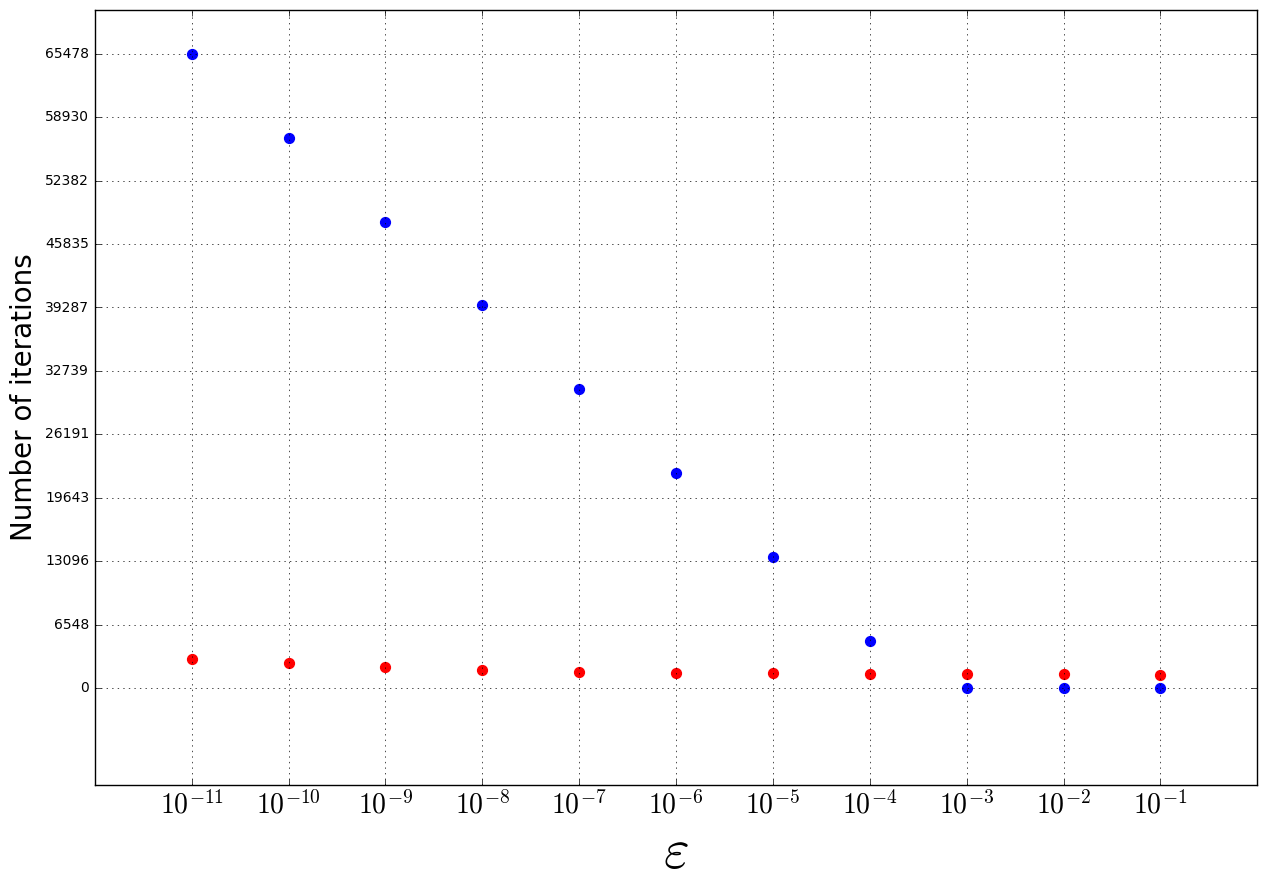

In [394]:
axis_font = {'size':'20'}
axis_font_eps = {'size':'40'}
x = [i for i in range(1, 12)]

fig = plt.figure(figsize=(15, 10))    
plt.scatter(x, counters_first, color='red', s=50, label=r'decreasing $\lambda$')
plt.scatter(x, counters_second, color='blue', s=50, label=r'constant $\lambda$')
plt.xlabel(r'$\varepsilon$', **axis_font_eps)
plt.ylabel(r'Number of iterations', **axis_font)
plt.xticks(x, list(map(lambda curr: r'$10^{-' + str(curr) + '}$', x[::-1])), **axis_font)
plt.yticks(np.linspace(np.max(counters_second), np.min(counters_second), 11))
plt.grid(True)
plt.show()

Как мы видим, примальньких $\varepsilon$ метод с константным шагом показывает себя сильно хуже, однако с увелиением погрешности, он становится выгоднее по количеству итераций.

# Задание 2 #

### Реализация метода Ньютона ###
Приведём реализацию демпфированного метода Ньютона для решения задачи $$ solve_{x,x_s,y,y_s \ge 0} \left( F \left( x, x_s, y, y_s, \mu \right) = 0\right) $$

In [2]:
Это назрело, на мой взгляд. Я не припомню запоминающихся тем после 7 сезонаEPS = 1e-4
N = 3
M = 2
A = np.matrix([[1, 2, -3], 
               [-1, -1, 1]
              ])
b = np.matrix([2, 6]).T
c = np.matrix([4, 1, -1]).T

def diag(point, shape):
    return np.identity(shape).reshape((shape, shape)) \
    * np.array(point.T).reshape(point.shape[0])

def ones_vector(shape):
    return np.matrix(np.ones(shape)).T

def FUNC(point, mu):
    return np.concatenate(
            (
            A * point[:N, 0] + point[N:N+M, 0] - b, 
            
            A.T * point[N+M:N+M+M, 0] - point[N+M+M:, 0] - c,
            
            diag(point[:N, 0], N) * diag(point[N+M+M:, 0], N) \
            * ones_vector(N) - mu * ones_vector(N),
            
            diag(point[N+M:N+M+M, 0], M) * diag(point[N:N+M, 0], M) \
            * ones_vector(M) - mu * ones_vector(M)
        ),
        axis=0
    )
    

def count_gradient(curr_point, mu, func):
    eps = 1e-4
    deltas = np.identity(2 * (N + M)) * eps
    #print((func((curr_point + deltas)[:, 1], mu) - func(curr_point, mu)))
    return np.concatenate(
            ([(func((curr_point + deltas)[:, i], mu) - func(curr_point, mu)) / eps
             for i in range(2 * (N + M))]), axis=1).T.I
    

def new_point(curr_point, mu, func):
    #print(count_gradient(curr_point, mu, func) * func(curr_point, mu))
    return curr_point - (count_gradient(curr_point, mu, func) * func(curr_point, mu))

def newton(func, start_point, mu):
    curr_point = start_point
    while (np.array((func(curr_point, mu))) ** 2).sum() > EPS:
        #print((curr_point))
        #if ((np.array((func(curr_point, mu))) ** 2).sum() < 10):
        #print((np.array((func(curr_point, mu))) ** 2).sum())
        curr_point = new_point(curr_point, mu, func)
    return curr_point

SyntaxError: invalid syntax (<ipython-input-2-df08914299d6>, line 1)

In [4]:
newton(FUNC, np.matrix([1,1,1,1,1,1,1,1,1,1]).T, 10)


NameError: name 'newton' is not defined

# Задание 3 #

Произведём генерацию всех данных для нашей задачи.

In [125]:
M = 200
a = np.array([6, 4, 3])
SIGMA = 0.1
time = np.linspace(0, 10 - (10/M), M)

def func(a):
    return a[0] * np.sin(time) + a[1] * time + a[2]

In [139]:
def plot_graph(x, y, y_1, y_2, y_3, axis, title):
    axis_font = {'size':'20'}

    fig = plt.figure(figsize=(15, 10))
    plt.axis(axis)
    plt.scatter(x[::2], y[::2], color='black', label='real function')
    plt.plot(x, y_1, color='red', label='min squares')
    plt.plot(x, y_2, color='green', label='min sum')
    plt.plot(x, y_3, color='blue', label='min max')
    plt.legend(prop=axis_font)
    plt.title(title, **axis_font)
    plt.grid(True)
    plt.show()

def plot_two_graph(x, y, y_1, y_2, y_3, axis, axis_2):
    plot_graph(x, y, y_1, y_2, y_3, axis, '')
    plot_graph(x, y, y_1, y_2, y_3, axis_2, 'Let\'s look some closer')    
    
def generate(a, sigma): 
    y_theory = a[0] * np.sin(time) + a[1] * time + a[2]
    y_real = y_theory \
        + np.array(ssp.norm.rvs(loc=0, scale=sigma, size=len(time)))
    return y_theory, y_real

In [140]:
y_theory, y_real = generate(a, SIGMA)

####  Метод наименьших квадратов ####

Будем находить приближенные значения методом наименьших квадратов.
Для этого нам надо минимизировать $\left\lVert Aa - b \right\lVert_2$, где $a = [a_1, a_2, a_3]$, а $b = [y_{1}^{real}, \dots, y_{m}^{real}]$.

Надо взять $$A = \left( \begin{matrix} sin t_1 & t_1 & 1 \\ sin t_2 & t_2 & 1 \\ \dots \\ sin t_m & t_m & 1\end{matrix}\right) $$

И по методу наименьших квадратов: $a = \left(A^T A\right)^{-1} A^T \vec{b}$

In [141]:
def min_squares(y_real):
    A = np.matrix([[np.sin(elem), elem, 1] for elem in time])
    answer = (A.T * A).I * A.T * np.matrix(y_real).T
    return np.array(answer).reshape(3)

#### Метод наименьшей суммы модулей ####
Нам надо минимизировать $\sum_{k=1}^m{\left| a_1 sin t_k + a_2 t_k + a_3 - y^{real}_k \right|}$
Заметим, что это эквивалентно решению следущей задачи ЛП:
$$ \sum_{k = 1}^{m}{z_i} \rightarrow min$$
$$ A \vec{a} - \vec{z} \le \vec{b} $$
$$ -A \vec{a} - \vec{z} \le -\vec{b} $$
Где $a_1, a_2, a_3, \vec{z}$ - переменные

In [142]:
def min_sum(y_real):
    func = np.array([0, 0, 0] + [1 for i in range(M)])
    A = np.matrix([[np.sin(elem), elem, 1] for elem in time])
    E = np.identity(M) * (-1)
    coeff = np.concatenate(
        (np.concatenate((A, A * (-1)), axis=0), 
        np.concatenate((E, E), axis=0)),
        axis=1)
    b = np.matrix(np.concatenate((y_real, y_real * (-1))))
    res = linprog(func, A_ub=coeff, b_ub=b,
                 options=dict(bland=True, tol=1e-8, maxiter=10 ** 6))
    return np.array(res.x[:3])

#### Метод наименьшего абсолютного значения ####
Нам надо минимизировать $\max\limits_{i \in [1, \dots, m]}{\left| a_1 sin t_k + a_2 t_k + a_3 - y^{real}_k \right|}$
Заметим, что это эквивалентно решению следущей задачи ЛП:
$$ z \rightarrow min$$
$$ A \vec{a} - z \le \vec{b} $$
$$ -A \vec{a} - z \le -\vec{b} $$
Где $a_1, a_2, a_3, z$ - переменные

In [143]:
def min_max(y_real):
    func = np.array([0, 0, 0, 1])
    A = np.matrix([[np.sin(elem), elem, 1] for elem in time])
    E = np.ones((2 * M, 1)) * (-1)
    coeff = np.concatenate(
        (np.concatenate((A, A * (-1)), axis=0), E), axis=1)
    b = np.matrix(np.concatenate((y_real, y_real * (-1))))
    res = linprog(func, A_ub=coeff, b_ub=b, 
                  options=dict(bland=True, tol=1e-8, maxiter=10 ** 6))
    return np.array(res.x[:3])

#### Построим графики функций: ####

In [144]:
f_min_squares = func(min_squares(y_real))
f_min_sum = func(min_sum(y_real))
f_min_max = func(min_max(y_real))
f = func(a)

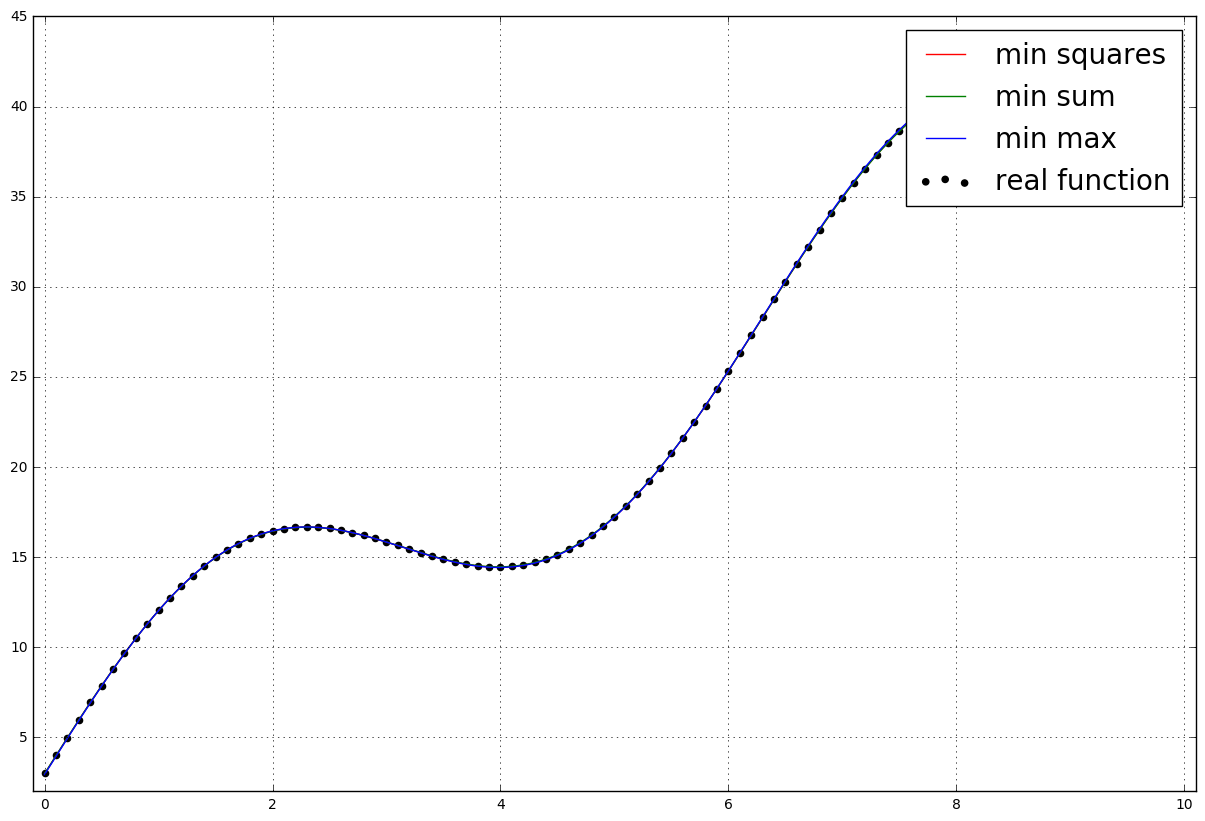

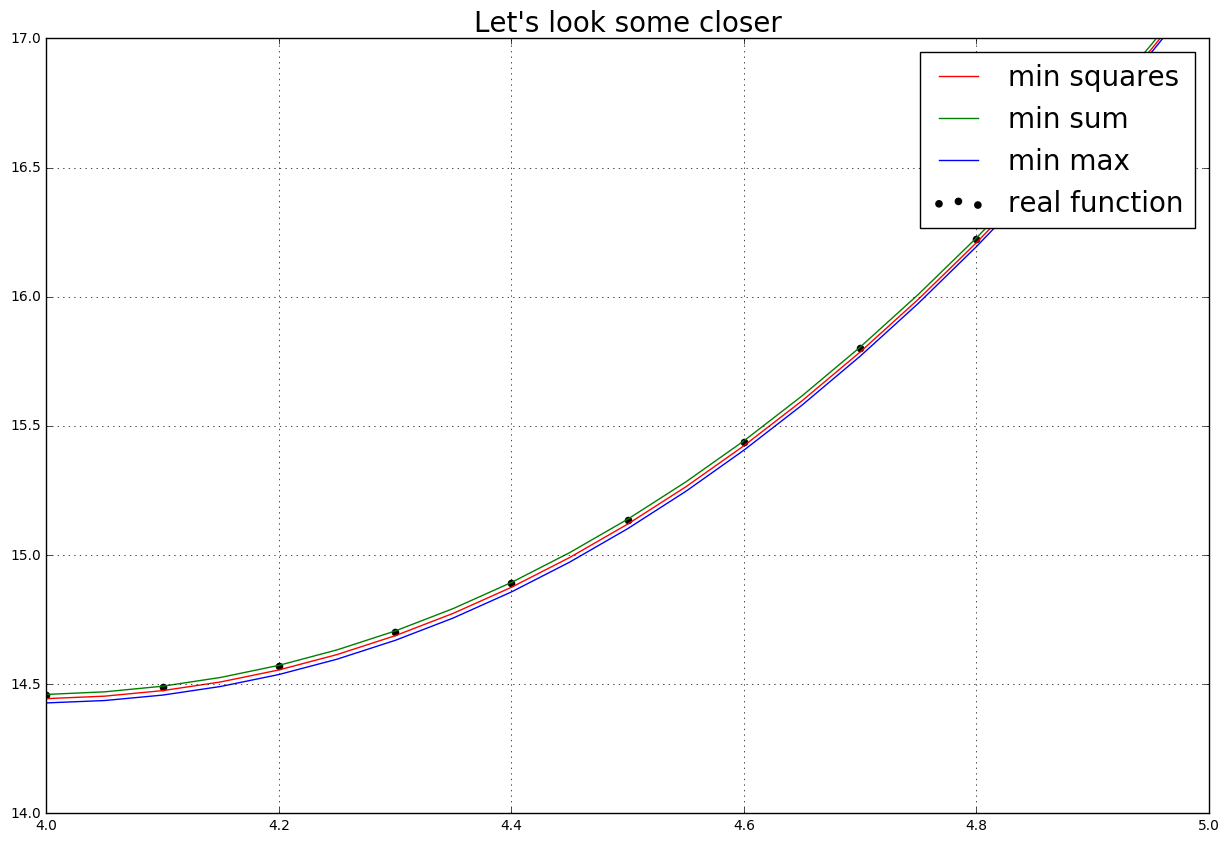

In [145]:
plot_two_graph(time, f, f_min_squares, 
               f_min_sum, f_min_max, 
               [-0.1,10.1,2,45], [4,5,14,17])

In [146]:
sigmas = np.linspace(0.01, 10, 30)
y_theory = []
y_real = []
for elem in sigmas:
    y_t, y_r = generate(a, elem)
    y_theory.append(y_t)
    y_real.append(y_r)
    
def get_diff(a, a_real):
    return ((a - a_real) ** 2).sum()

In [147]:
output = [[] for i in range(len(sigmas))]
for i in range(len(sigmas)):
    output[i].append(get_diff(a, min_squares(y_real[i])))
    output[i].append(get_diff(a, min_sum(y_real[i])))
    output[i].append(get_diff(a, min_max(y_real[i])))

In [148]:
#for i in range(len(sigmas)):
    #print(str(sigmas[i]) + ': ' + output[i][0] \
          #+ ', ' + output[i][1] + ', ' + output[i][2])

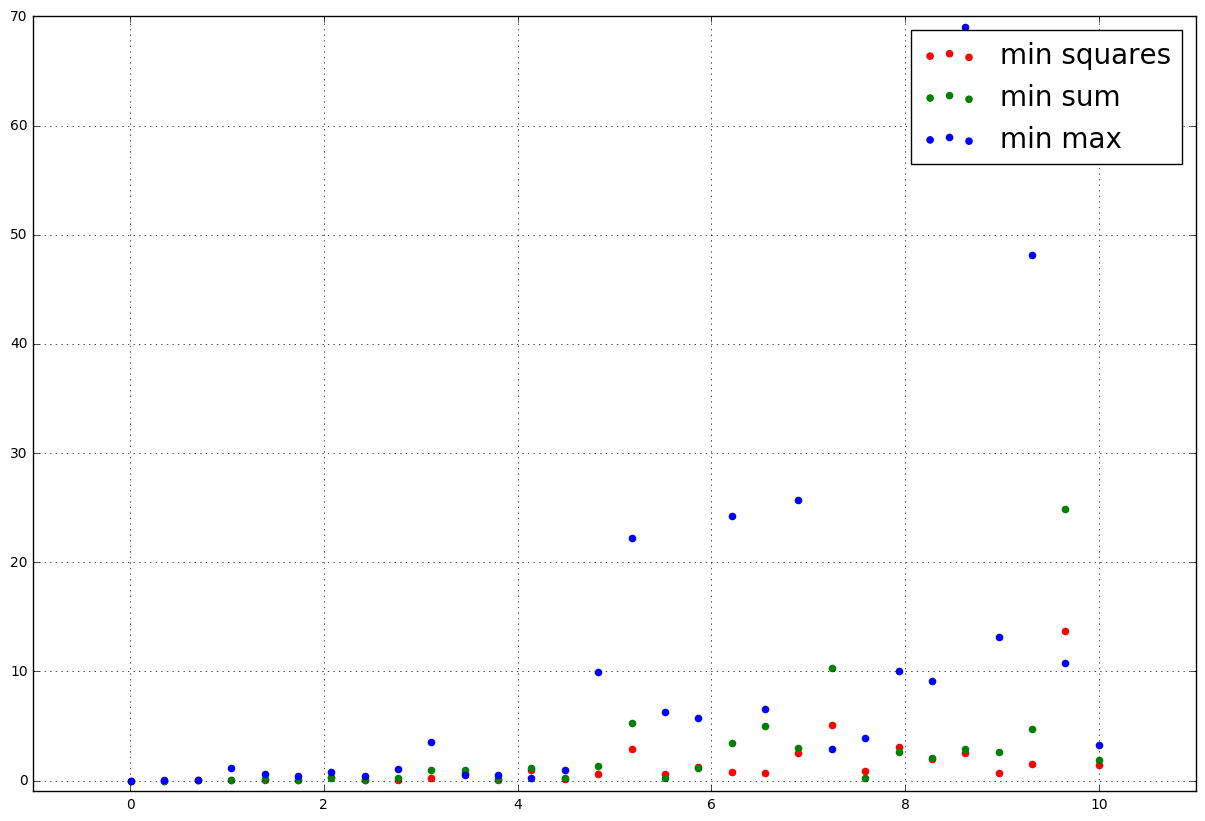

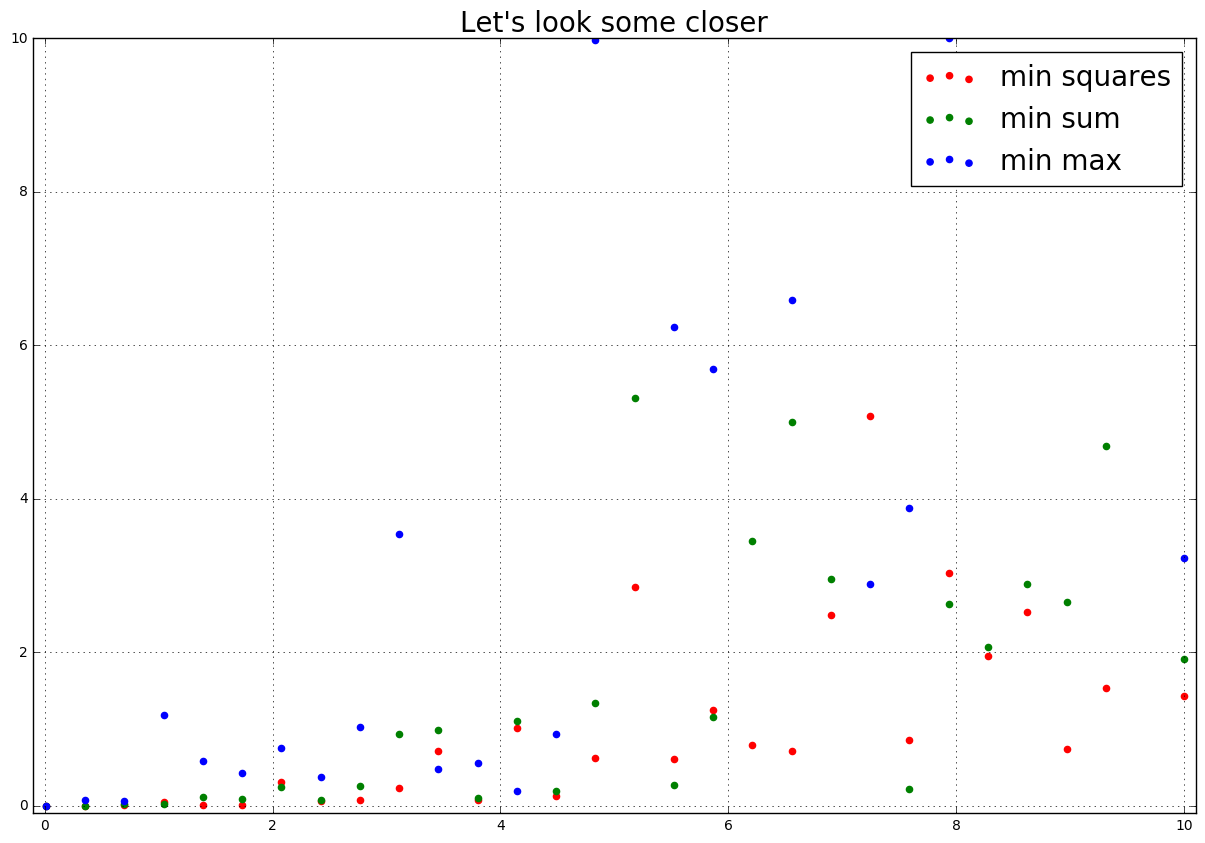

In [149]:
output = np.array(output)

axis_font = {'size':'20'}

fig = plt.figure(figsize=(15, 10))
plt.axis([-1, 11, -1, 70])
plt.scatter(sigmas, output[:, 0], color='red', label='min squares')
plt.scatter(sigmas, output[:, 1], color='green', label='min sum')
plt.scatter(sigmas, output[:, 2], color='blue', label='min max')
plt.legend(prop=axis_font)
plt.grid(True)
plt.show()



fig = plt.figure(figsize=(15, 10))
plt.axis([-0.1, 10.1, -0.1, 10])
plt.scatter(sigmas, output[:, 0], color='red', label='min squares')
plt.scatter(sigmas, output[:, 1], color='green', label='min sum')
plt.scatter(sigmas, output[:, 2], color='blue', label='min max')
plt.legend(prop=axis_font)
plt.title('Let\'s look some closer', **axis_font)
plt.grid(True)
plt.show()


In [150]:
y_theory, y_real = generate(a, SIGMA)
y_real[0] += 50
y_real[-1] -= 50
f_min_squares = func(min_squares(y_real))
f_min_sum = func(min_sum(y_real))
f_min_max = func(min_max(y_real))
f = func(a)

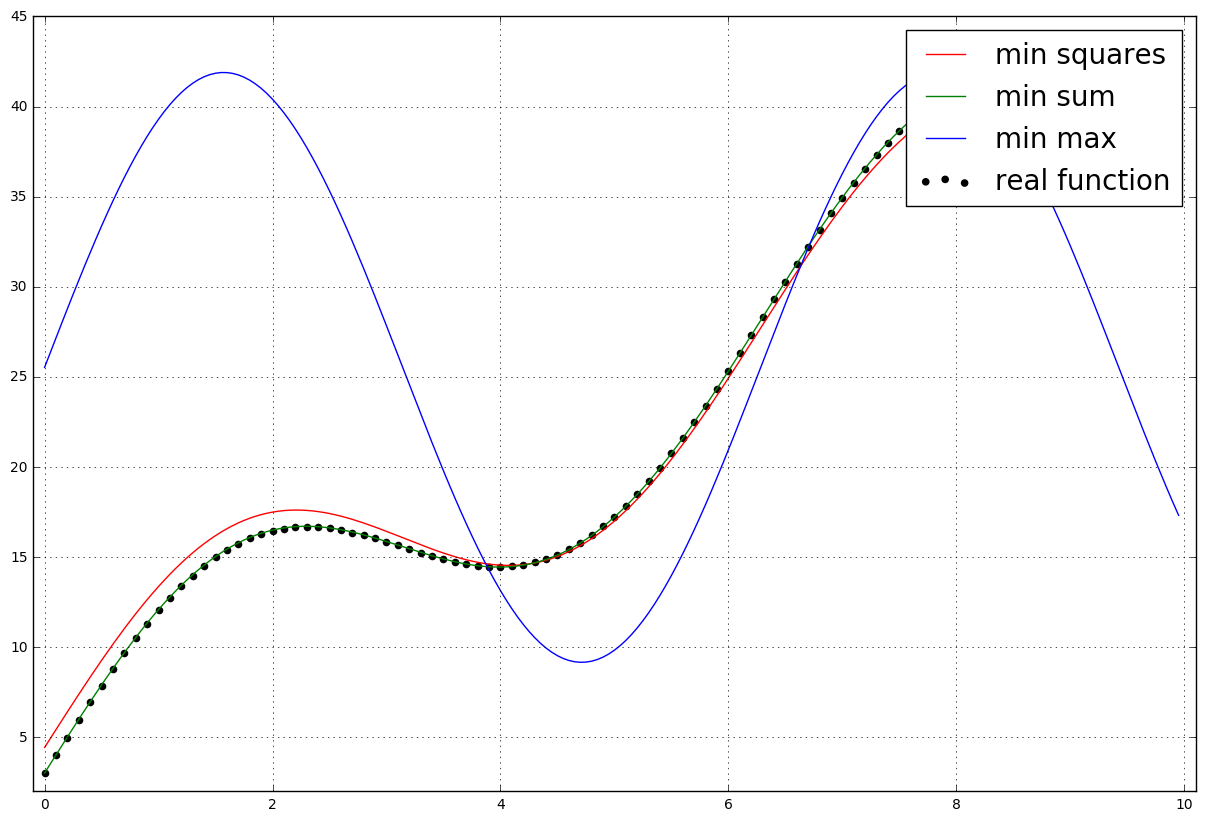

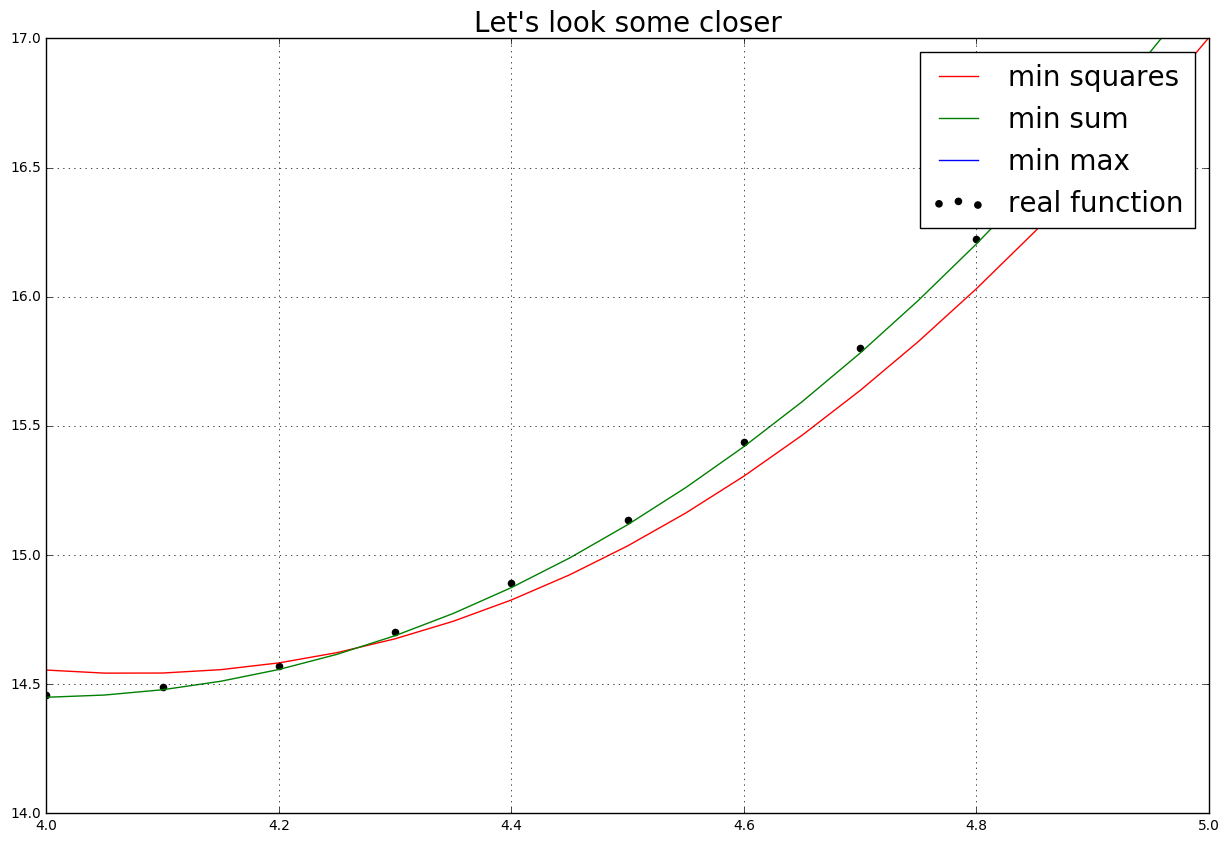

In [151]:
plot_two_graph(time, f, f_min_squares, 
               f_min_sum, f_min_max, 
               [-0.1,10.1,2,45], [4,5,14,17])